In [1]:
# The imports
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#Outputting the price table of a certain stock, which is currently Apple
stock = 'AAPL'

stock_data = yf.Ticker(stock)
stock_data = stock_data.history(period="10y")

del stock_data["Dividends"]
stock_data["Tomorrow"] = stock_data["Close"].shift(-1)
stock_data["Target"] = (stock_data["Tomorrow"] > stock_data["Close"]).astype(int)

stock_data

c:\Users\kashy\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:777: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Volume,Stock Splits,Tomorrow,Target
Date,,,,,,,,
2014-05-20 00:00:00-04:00,19.096797,19.156502,18.977384,19.103115,234836000,0.0,19.153664,1
2014-05-21 00:00:00-04:00,19.075319,19.165983,19.019405,19.153664,196859600,0.0,19.183990,1
2014-05-22 00:00:00-04:00,19.162826,19.265495,19.083850,19.183990,200760000,0.0,19.400700,1
2014-05-23 00:00:00-04:00,19.183357,19.419654,19.158716,19.400700,232209600,0.0,19.763990,1
2014-05-27 00:00:00-04:00,19.455982,19.771255,19.448085,19.763990,348866000,0.0,19.712818,0
...,...,...,...,...,...,...,...,...
2024-05-14 00:00:00-04:00,187.509995,188.300003,186.289993,187.429993,52393600,0.0,189.720001,1
2024-05-15 00:00:00-04:00,187.910004,190.649994,187.369995,189.720001,70400000,0.0,189.839996,1
2024-05-16 00:00:00-04:00,190.470001,191.100006,189.660004,189.839996,52845200,0.0,189.869995,1


c:\Users\kashy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kashy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'The Stock Price')

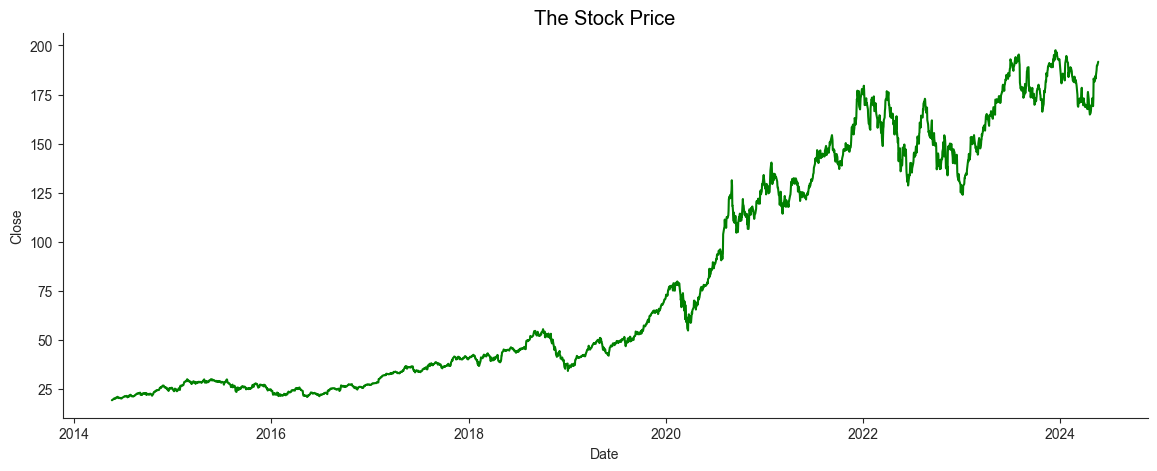

In [4]:
# The below is to plot the stocks over time.
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=stock_data,x="Date",y='Close',color='green')
sns.despine()
plt.title("The Stock Price",size='x-large',color='black')

In [5]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.95)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 123803 (483.61 KB)
Trainable params: 123803 (483.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=1)

2333/2333 [==============================] - 170s 68ms/step - loss: 0.0021


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4/4 [==============================] - 0s 56ms/step


ValueError: operands could not be broadcast together with shapes (125,3) (125,) 

C:\Users\kashy\AppData\Local\Temp\ipykernel_80420\3670645671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


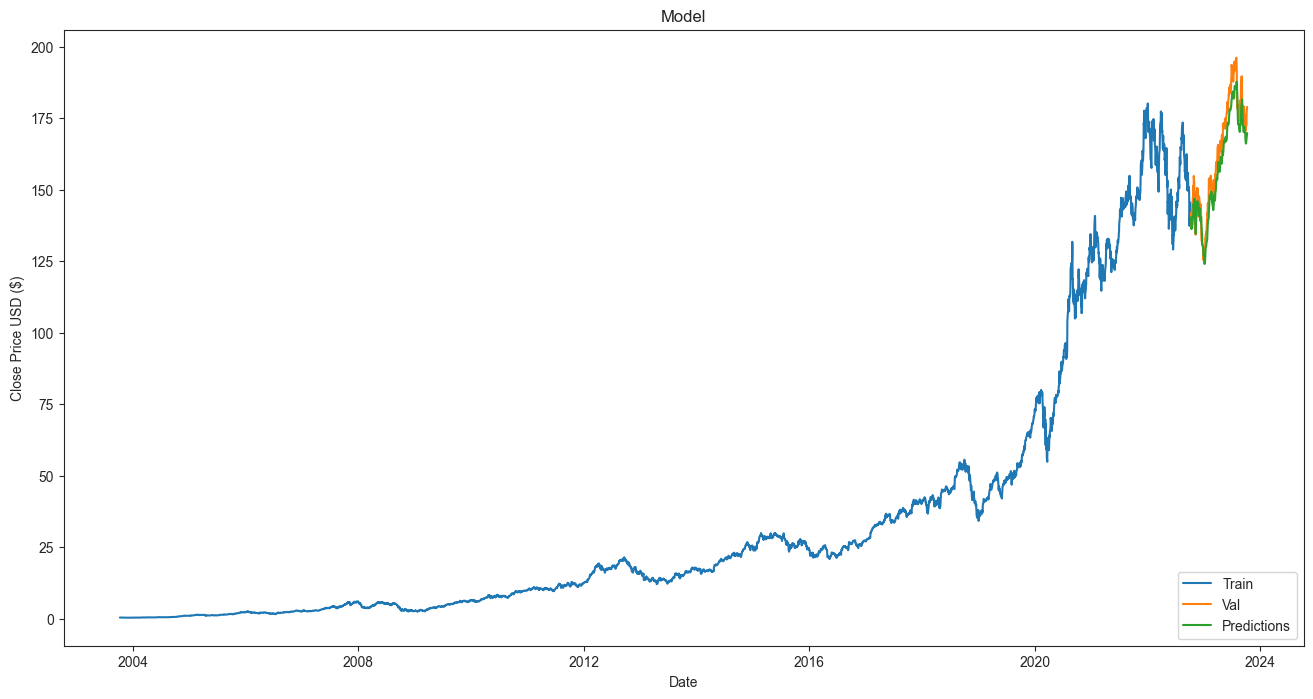

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
test = validation['Close']
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
count = 0

for index in range(len(predictions)):
    if abs(predictions[index] - test[index]) <= 0.04 * predictions[index]:
        count += 1

print(count / len(predictions))

0.6135458167330677
